In [1]:
# -*- coding: utf-8 -*-
from collections import defaultdict

import json
import matplotlib.pyplot as plt
import numpy as np
import openturns as ot
import pickle

from pce_interaction import *

### MATPLOTLIB CONFIGURATION ###
plt.rcParams['figure.dpi']= 500
plt.rcParams['text.usetex'] = True

# Importing data

In [2]:
### PCE METAMODEL ###
with open('../../data/PCE_metamodel.pkl', "rb") as f:
    unpickler = pickle.Unpickler(f)
    pce = unpickler.load()

In [3]:
### TIME INDICES ###
operation_time = np.load('../../data/SG_time.npy')

In [4]:
### INPUT VARIABLES LABELS ###
labels = [r'$\alpha$',
          r'$\beta$',
          r'$\epsilon_{e}$',
          r'$\epsilon_{c}$', 
          r'$d_{p}$',
          r'$\Gamma_{p}(0)$',
          r'$a_{v}$']

In [5]:
### PARAMETERS OF THE STEAM GENERATOR ###
input_dic = {}
input_dic['SG'] = json.load(open('../../data/SG_cleaning_conditioning.json'))

In [6]:
### NEW COLOR SCHEME FOR CHEMICAL CONDITIONING ###
colors_n_chem_cond = {'C1': {'name': r'$\chi_{1}$', 'low': 'gainsboro', 'high': 'silver'},
                      'C2': {'name': r'$\chi_{2}$', 'high': 'darkgray'}}

# 3.1 Time-dependent Sobol' indices

# Variance plot

In [67]:
inputDistribution = pce.getDistribution()
inputDescription = inputDistribution.getDescription()

In [68]:
# Gather intermediate data
inputSample = pce.getInputSample()
sampleSize = inputSample.getSize()
inputDimension = inputSample.getDimension()
outputSample = pce.getOutputSample()
outputDimension = outputSample.getDimension()

Sample size =  750
Input dimension =  7
Output dimension = 75


In [69]:
# Get the part of variance of each multi-index
functionalChaosSobolIndices = ot.FunctionalChaosSobolIndices(pce)
input_dimension = pce.getInputSample().getDimension()
indices = pce.getIndices()
number_of_coefficients = len(indices)
print("Number of coefficients = ", number_of_coefficients)

# %%
# Compute the part of variance of each coefficient
interaction_sobol_indices, group_list = ComputeInteractionSobolIndices(pce)
number_of_groups = len(group_list)
print("Number of groups = ", number_of_groups)

Number of coefficients =  462
Number of groups =  92


In [70]:
### SET A SENSITIVITY THRESHOLD ###
sensitivity_threshold=0.0001
group_list_threshold = []
interaction_sobol_indices_threshold = ot.Sample(0, outputDimension)
for group_index in range(number_of_groups):
    if interaction_sobol_indices[group_index,:].normInf() > sensitivity_threshold:
        group_list_threshold.append(group_list[group_index])
        interaction_sobol_indices_threshold.add(interaction_sobol_indices[group_index])


In [72]:
group_labels_with_description_threshold = ComputeGroupLabelsFromLabelNames(inputDescription, group_list_threshold)

In [73]:
labels_groups = ['[$\\alpha$]',
                 '[$\\beta$]', 
                 '[$\\epsilon_e$]', 
                 '[$\\epsilon_c$]', 
                 '[$d_p$]', 
                 '[$\\Gamma_p(0)$]', 
                 '[$a_v$]']

In [74]:
label_indices = []
for i in range(len(group_labels_with_description_threshold)):
    for label in labels_groups:
        if group_labels_with_description_threshold[i] == label:
            label_indices.append(i)

In [76]:
interaction_sensitivity_remainder = 1.0 - np.sum(interaction_sobol_indices_threshold, axis = 0)
interaction_sobol_indices_threshold.add(interaction_sensitivity_remainder)
number_of_groups_threshold = len(interaction_sobol_indices_threshold)

group_labels_with_description_threshold.append("*")
number_of_groups_threshold = len(interaction_sobol_indices_threshold)
print("Number of thresholded groups = ", number_of_groups_threshold)

Number of thresholded groups =  72


In [77]:
pceRandomVector = ot.FunctionalChaosRandomVector(pce)
pceCovariance = pceRandomVector.getCovariance()
pceVariance = [pceCovariance[i, i] for i in range(outputDimension)]


In [78]:
cumulated_variances = ot.Sample(1, outputDimension)
cumulated_variances.add(np.cumsum(interaction_sobol_indices_threshold, axis=0))

In [79]:
pceVariance = np.asarray(pceVariance)
cumulated_variances = np.asarray(cumulated_variances)

In [81]:
variance_output = []
for group_index in range(number_of_groups_threshold):
    var = [pceVariance[k] * (cumulated_variances[1 + group_index, k] - cumulated_variances[group_index, k]) for k in range(outputDimension)]
    variance_output.append(var)
#Select the variance only of the labels
variance_output = np.asarray(variance_output)[label_indices]

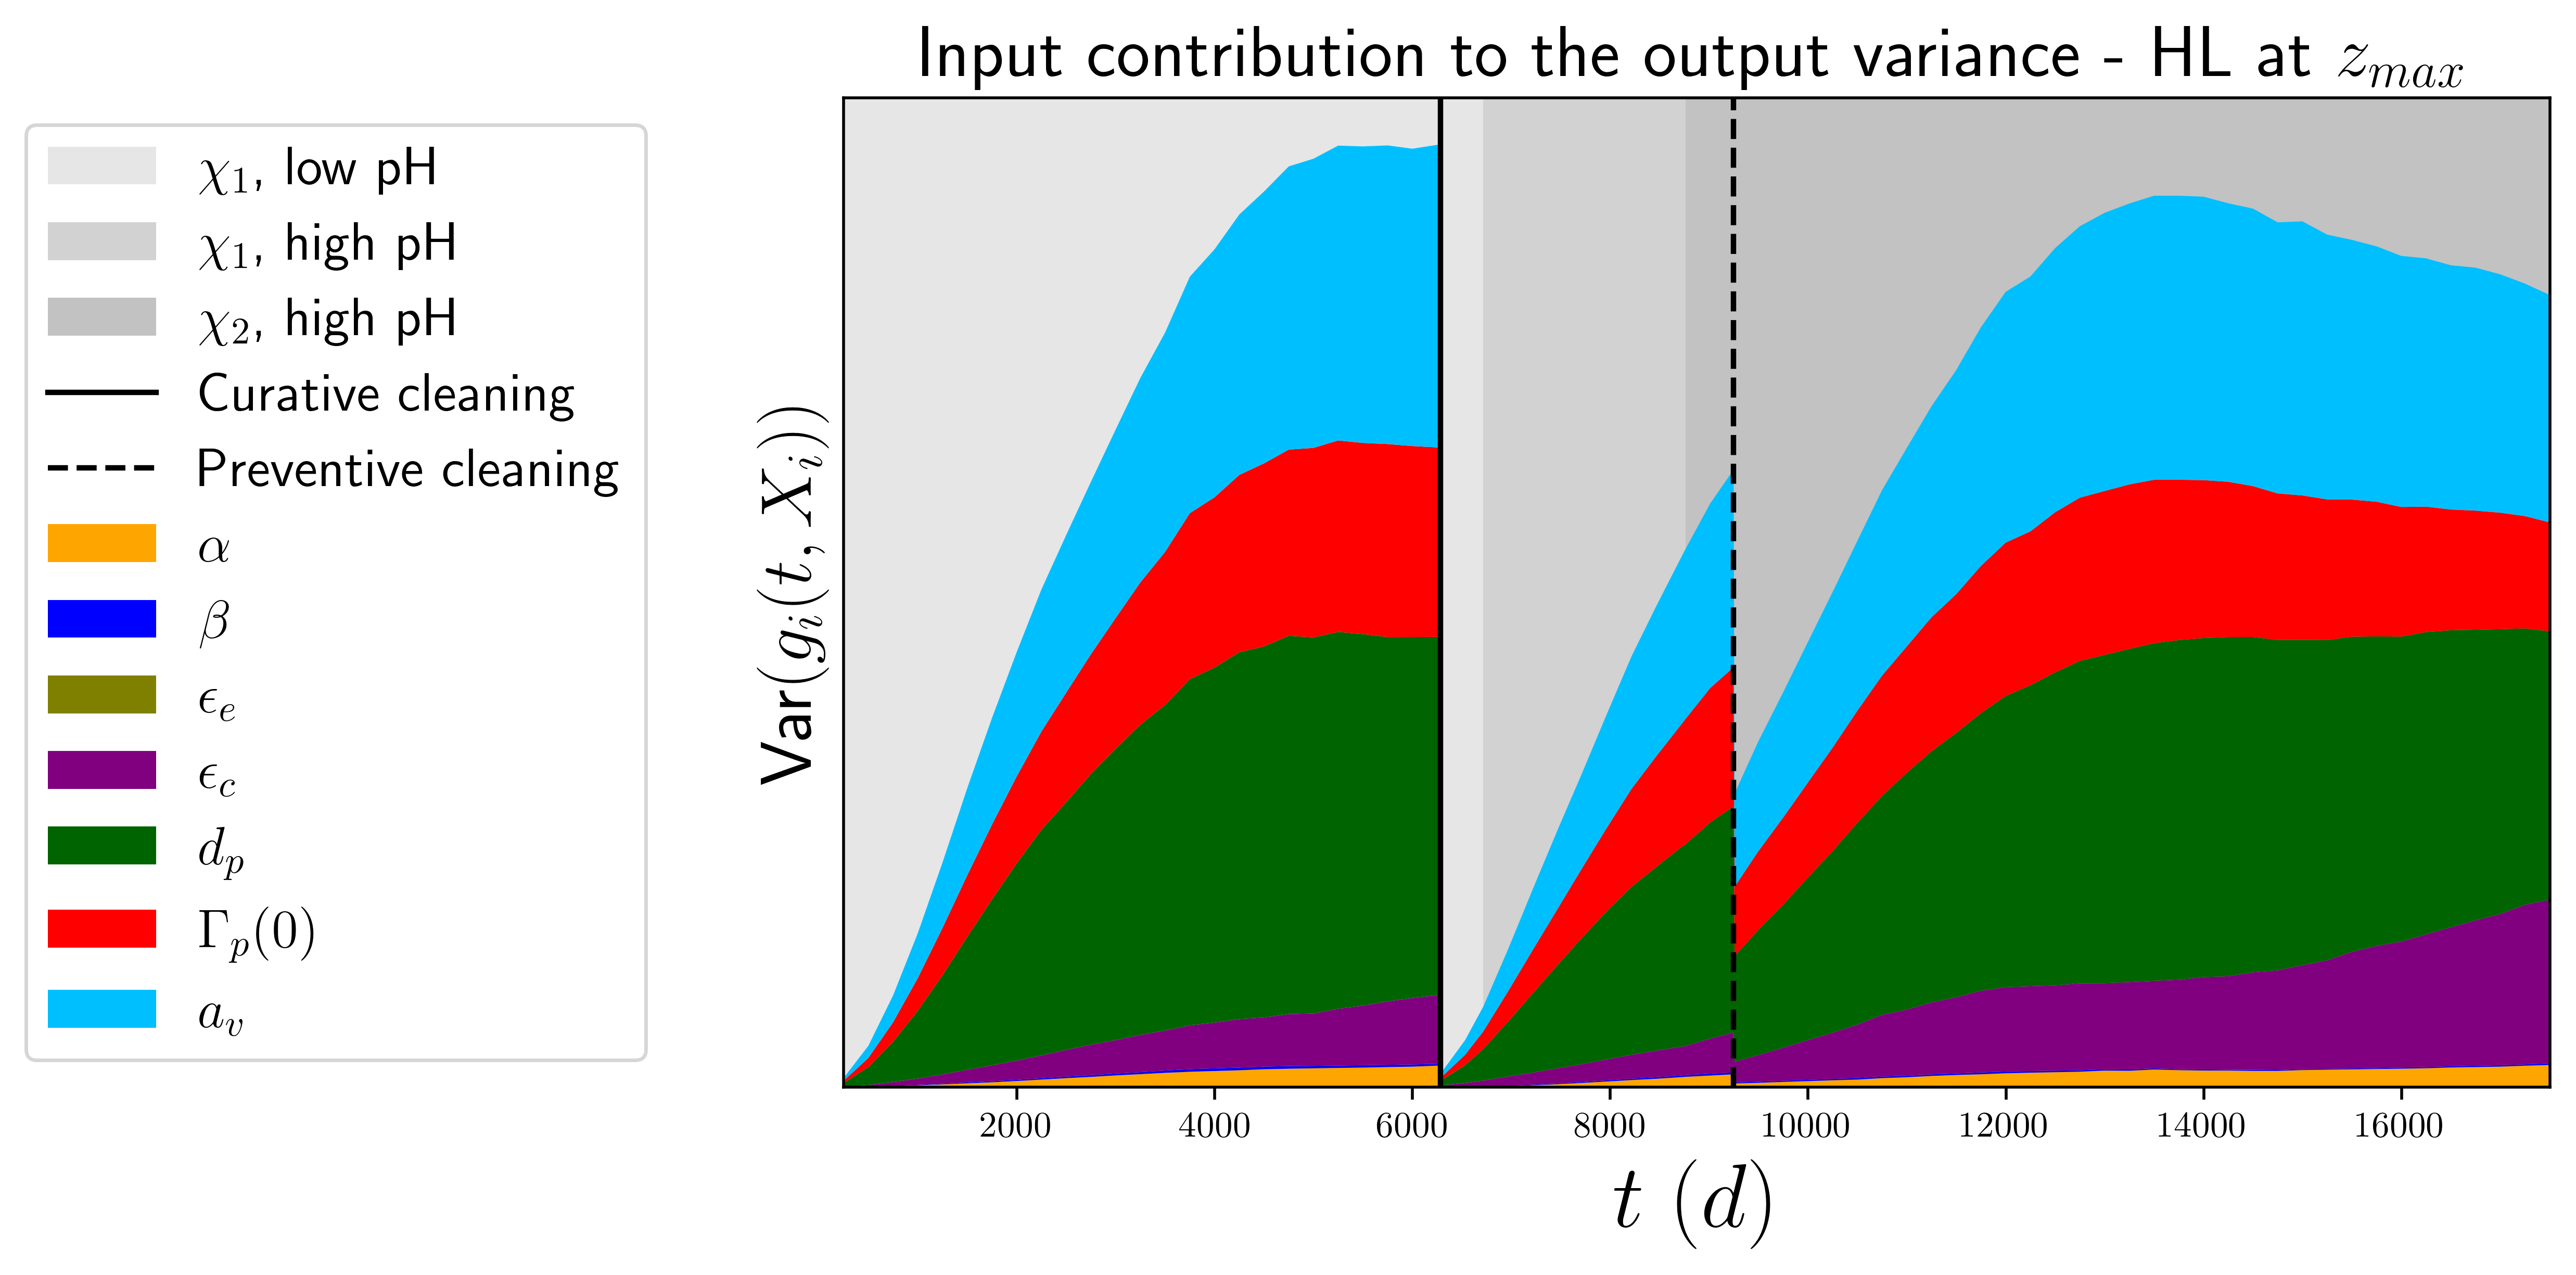

In [86]:
fig, axs = plt.subplots(1, 1, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue', 'yellow']

cond = input_dic['SG']['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(operation_time)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs.axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))

#Cleaning dates
nett = input_dic['SG']['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs.axvline(x=nett[k]['time']/24, color='k', linestyle='-', linewidth=1.5, label='Curative cleaning')

    elif nett[k]['type'] == 'preventive':
        axs.axvline(x=nett[k]['time']/24, color='k', linestyle='--', linewidth=1.5, label='Preventive cleaning')


axs.stackplot(operation_time, variance_output, labels=labels, colors=colors)
axs.set_xlim(250,17500)
axs.set_yticks([])
axs.set_xlabel(r'$t\;(d)$', fontsize=25)
axs.set_ylabel(r'Var$(g_{i}(t,{X}_{i}))$', fontsize=20)
axs.set_title(r'Input contribution to the output variance - HL at $z_{max}$', fontsize=20)

axs.legend(bbox_to_anchor=(-0.1,1.0), fontsize=15)


fig.savefig('../../plots/Sobol\'/variance_output.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/Sobol\'/variance_output.png', format='png', bbox_inches='tight')


## First and Total order Sobol' indices time variation

In [7]:
### GET THE SOBOL INDICES FROM PCE OBJECT ###
pce_sobol = ot.FunctionalChaosSobolIndices(pce) 

In [8]:
### GET THE FIRST-ORDER AND TOTAL SOBOL INDICES ###
sobol_first_order, sobol_total = [], []
for i in range(len(labels)):
    sobol_i_f, sobol_i_t = [], []
    for j in range(75):
        sobol_i_f.append(pce_sobol.getSobolIndex(i, j))
        sobol_i_t.append(pce_sobol.getSobolTotalIndex(i, j))
    sobol_first_order.append(sobol_i_f)
    sobol_total.append(sobol_i_t)
sobol_first_order, sobol_total = np.asarray(sobol_first_order), np.asarray(sobol_total)

In [9]:
### GET THE INTERACTION INDICES ###
sobol_interaction = []
for i in range(75):
    s = 1 - np.sum(np.asarray(sobol_first_order)[:, i])
    sobol_interaction.append(s)
sobol_interaction = np.asarray(sobol_interaction)

In [10]:
sobol_f = np.concatenate((sobol_first_order, sobol_interaction.reshape(1, 75)), axis=0)

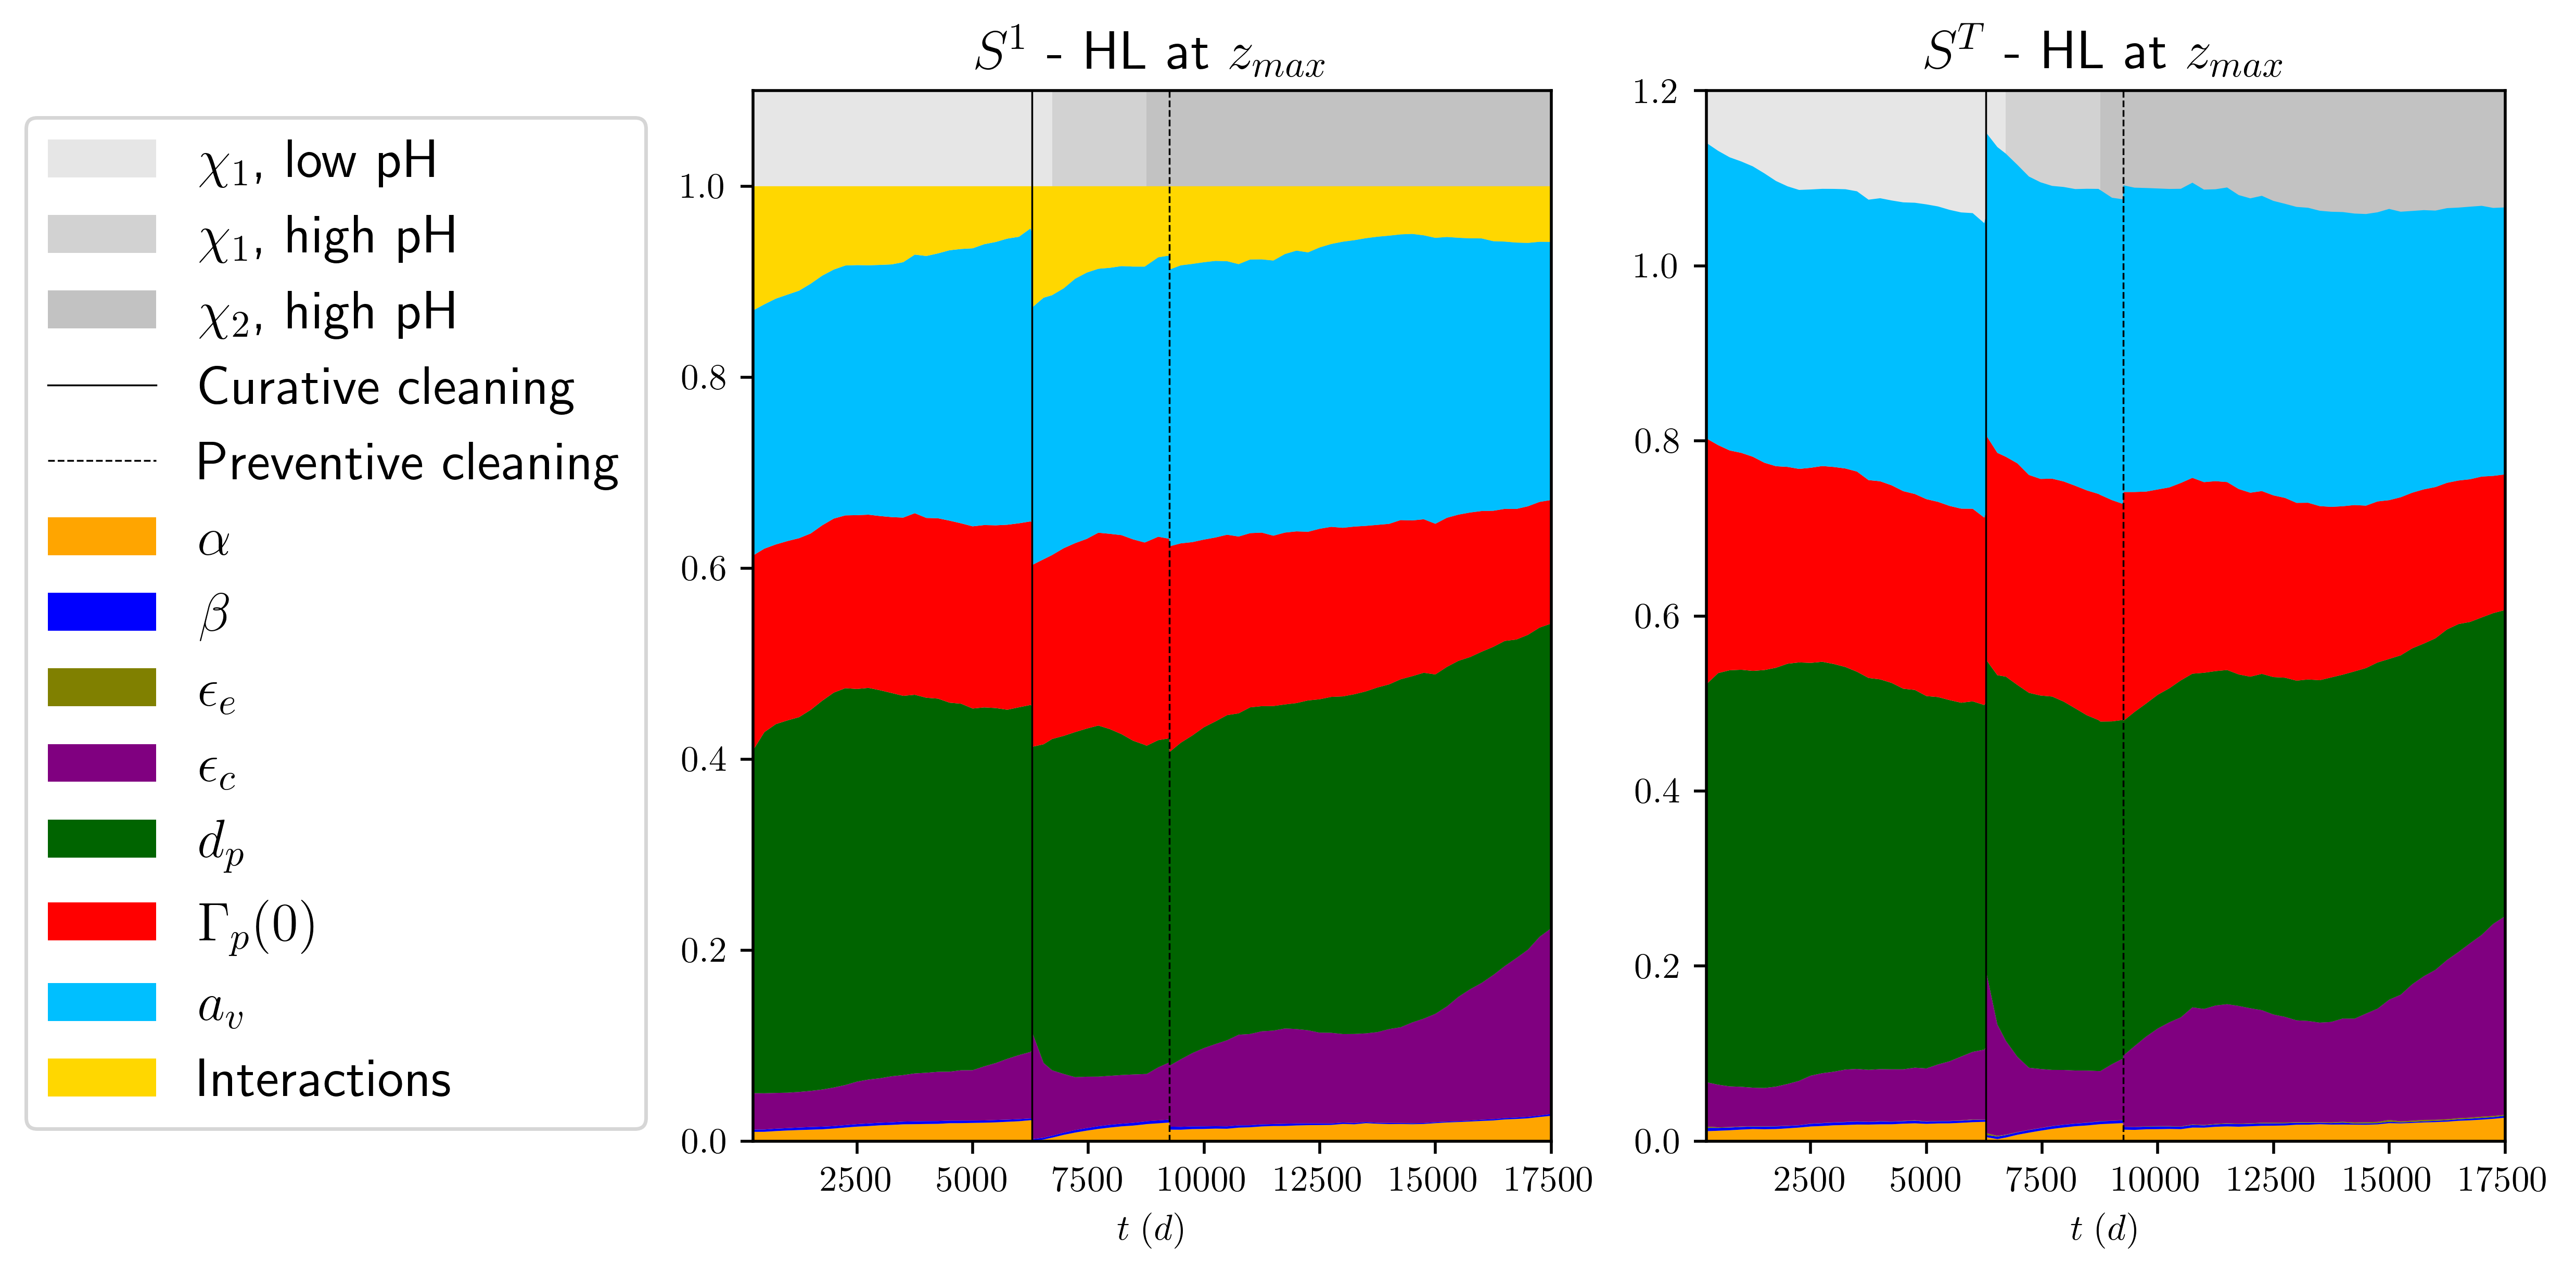

In [66]:
### FIG 9 ###

fig, axs = plt.subplots(1, 2, figsize=(10,5), layout='tight')
colors = ['orange', 'blue', 'olive','purple', 'darkgreen', 'red','deepskyblue', 'gold']

#Chemical conditioning
cond = input_dic['SG']['chemistry']['conditioning']
for k in range(len(cond)):
    if k == len(cond)-1:
        t_i, t_f = cond[k]['time']/24, max(operation_time)
    else:
        t_i, t_f = cond[k]['time']/24, cond[k+1]['time']/24
    c = cond[k]
    typ = colors_n_chem_cond[c['type']]
    col = typ[str(c['ph'])]
    axs[0].axvspan(t_i, t_f, facecolor=col, alpha=0.7, label='{0}, {1} pH'.format(typ['name'], c['ph']))
    axs[1].axvspan(t_i, t_f, facecolor=col, alpha=0.7)

nett = input_dic['SG']['chemistry']['cleaning']
for k in range(len(nett)):
    if nett[k]['type'] == 'curative':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5, label='Curative cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='-', linewidth=0.5)
        
    elif nett[k]['type'] == 'preventive':
        axs[0].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5, label='Preventive cleaning')
        axs[1].axvline(x=nett[k]['time']/24, color = 'k', linestyle='--', linewidth=0.5)

axs[0].stackplot(operation_time, sobol_f, labels=labels + ["Interactions"], colors=colors)
axs[0].set_xlim(250,17500)
axs[0].set_ylim(0,1.1)
axs[0].set_xlabel(r'$t\;(d)$')
axs[0].set_title(r'$S^{1}$ - HL at $z_{max}$', fontsize=15)

axs[1].stackplot(operation_time, sobol_total, labels=labels, colors=colors)
axs[1].set_xlim(250,17500)
axs[1].set_ylim(0,1.2)
axs[1].set_xlabel(r'$t\;(d)$')
axs[1].set_title(r'$S^{T}$ - HL at $z_{max}$',  fontsize=15)

axs[0].legend(bbox_to_anchor=(-0.1,1.0), fontsize=15)

fig.savefig('../../plots/Sobol\'/PCE_S_1_T.pdf', format='pdf', bbox_inches='tight')
fig.savefig('../../plots/Sobol\'/PCE_S_1_T.png', format='png', bbox_inches='tight')